# Solução Numérica das Equações Difusivas de Streeter-Phelps (EDPs)

# Resumo

Este trabalho apresenta a solução numérica do sistema de equações diferenciais parciais (EDPs) difusivas de Streeter-Phelps, que modelam a dinâmica da Demanda Bioquímica de Oxigênio (DBO) e do Oxigênio Dissolvido (OD) em um corpo d'água como um rio. Utiliza-se o Método das Linhas (MOL), onde as derivadas espaciais são discretizadas por diferenças finitas, transformando o sistema de EDPs em um grande sistema de Equações Diferenciais Ordinárias (EDOs) acopladas no tempo. Este sistema de EDOs é então resolvido utilizando um integrador numérico robusto (`solve_ivp` do SciPy). A análise foca na evolução espaço-temporal das concentrações de DBO e OD, ilustrando a formação e propagação da "curva de sag" do oxigênio dissolvido sob condições específicas de poluição inicial ou contínua e características do rio.

# Introdução e Problemática

A qualidade da água em rios é crucial para os ecossistemas aquáticos e para o uso humano. A modelagem matemática da interação entre a poluição orgânica (medida pela DBO) e o Oxigênio Dissolvido (OD) é essencial para prever os impactos de descargas de poluentes e avaliar a capacidade de autodepuração dos rios. O modelo de Streeter-Phelps, em sua forma difusiva, captura os processos chave de transporte (advecção pela correnteza e dispersão longitudinal) e reações bioquímicas (decaimento da DBO, consumo de OD e reaeração atmosférica).

Resolver as EDPs completas permite analisar cenários complexos e dinâmicos, como a resposta a uma descarga de poluição em um ponto específico, a evolução temporal da qualidade da água ao longo de um trecho de rio, e o efeito de condições de contorno variáveis. Esta abordagem é mais geral do que métodos que buscam soluções específicas, como as ondas viajantes.

# Objetivos

Os principais objetivos deste projeto são:

1.  **Implementar o Modelo de EDPs:** Formular o sistema de EDPs difusivas de Streeter-Phelps (com cinética de DBO linear ou não-linear).
2.  **Aplicar o Método das Linhas (MOL):** Discretizar o domínio espacial do rio usando uma malha de pontos e aproximar as derivadas espaciais (advecção e difusão) por diferenças finitas.
3.  **Derivar o Sistema de EDOs:** Obter o sistema de EDOs acopladas no tempo resultante da discretização espacial.
4.  **Implementar Condições de Contorno e Iniciais:** Definir condições realistas ou ilustrativas para o estado inicial do rio e para suas fronteiras (montante e jusante).
5.  **Resolver Numericamente o Sistema de EDOs:** Utilizar `solve_ivp` para integrar o sistema de EDOs no tempo e obter a evolução das concentrações de DBO e OD em cada ponto da malha espacial.
6.  **Analisar os Resultados Espaço-Temporais:** Visualizar e interpretar a solução, observando a propagação da poluição, a formação da curva de sag do OD no espaço e no tempo, e a influência dos parâmetros.

# Fonte dos Dados e Parâmetros

Os parâmetros do modelo (velocidade, dispersão, taxas de reação, saturação de OD) foram baseados em valores típicos da literatura [e.g., 2, 3] ou no artigo de referência [1], adaptados para esta simulação de EDP. Parâmetros adicionais necessários para a simulação de EDPs incluem:
* Comprimento do trecho do rio (`L`).
* Número de pontos da malha espacial (`Nx`).
* Tempo final da simulação (`T_final`).
* Condições iniciais (`b(x,0)`, `D(x,0)`).
* Condições de contorno (concentrações na entrada `x=0`, condição na saída `x=L`).

Valores específicos são detalhados na seção de código. Uma aplicação real exigiria calibração com dados de campo.

# Modelo Matemático e Método Numérico (MOL)

O sistema de EDPs difusivas de Streeter-Phelps é dado por:

**(EDP para DBO - `b(x,t)`):**
`∂b/∂t = -v ∂b/∂x + K ∂²b/∂x² - k₃ * f(b) + S_b(x,t)`

**(EDP para OD - `D(x,t)`):**
`∂D/∂t = -v ∂D/∂x + K ∂²D/∂x² - k₁ * f(b) + k₂(Ds - D) + S_D(x,t)`

Onde `f(b)` é a função de decaimento da DBO (assumida `f(b)=b` linear nesta implementação inicial, mas pode ser Monod: `f(b) = b / (K_b + b)`), e `S_b`, `S_D` são termos de fonte/sumidouro (aqui `S_b = bₐ` e `S_D = 0` conforme código anterior, mas poderiam ser funções de `x` e `t`). Os outros parâmetros (`v, K, k₁, k₂, k₃, Ds`) são como definidos anteriormente.

**Método das Linhas (MOL):**
Discretizamos o domínio espacial `[0, L]` em `Nx+1` pontos: `x_i = i * dx`, onde `dx = L / Nx` para `i = 0, 1, ..., Nx`.
As concentrações em cada ponto `i` no tempo `t` são `b_i(t) = b(x_i, t)` e `D_i(t) = D(x_i, t)`.
Aproximamos as derivadas espaciais nos pontos internos (`i = 1, ..., Nx-1`) usando diferenças finitas centradas (2ª ordem):
`∂b/∂x |_(x_i) ≈ (b_{i+1}(t) - b_{i-1}(t)) / (2*dx)`
`∂²b/∂x² |_(x_i) ≈ (b_{i+1}(t) - 2*b_i(t) + b_{i-1}(t)) / dx²`
(e similarmente para `D`).

Substituindo essas aproximações nas EDPs, obtemos um sistema de `2 * (Nx - 1)` EDOs para os pontos internos (assumindo que os pontos `i=0` e `i=Nx` são definidos pelas condições de contorno):

`db_i/dt = -v * (b_{i+1} - b_{i-1}) / (2*dx) + K * (b_{i+1} - 2*b_i + b_{i-1}) / dx² - k₃ * b_i + bₐ`
`dD_i/dt = -v * (D_{i+1} - D_{i-1}) / (2*dx) + K * (D_{i+1} - 2*D_i + D_{i-1}) / dx² - k₁ * b_i + k₂(Ds - D_i)`

para `i = 1, ..., Nx-1`.

**Condições de Contorno:**
* **Montante (Entrada, `x=0`, `i=0`):** Frequentemente tipo Dirichlet, fixando as concentrações de entrada. `b_0(t) = b_in`, `D_0(t) = D_in`.
* **Jusante (Saída, `x=L`, `i=Nx`):** Frequentemente tipo Neumann de fluxo zero, `∂b/∂x = 0`, `∂D/∂x = 0`. Isso pode ser implementado ajustando as EDOs nos pontos próximos à fronteira (`i=Nx-1`) ou usando pontos 'fantasmas'. Uma aproximação comum é `b_{Nx} = b_{Nx-1}` e `D_{Nx} = D_{Nx-1}`.

**Solução Numérica:**
O sistema completo de EDOs (incluindo a implementação das condições de contorno) é da forma `dY/dt = F(t, Y)`, onde `Y` é o vetor de estado contendo todas as `b_i` e `D_i` nos pontos da malha. Este sistema é resolvido usando `solve_ivp` a partir de um estado inicial `Y(0)`.

Matplotlib is building the font cache; this may take a moment.


Iniciando integração das EDOs...
Integração concluída.


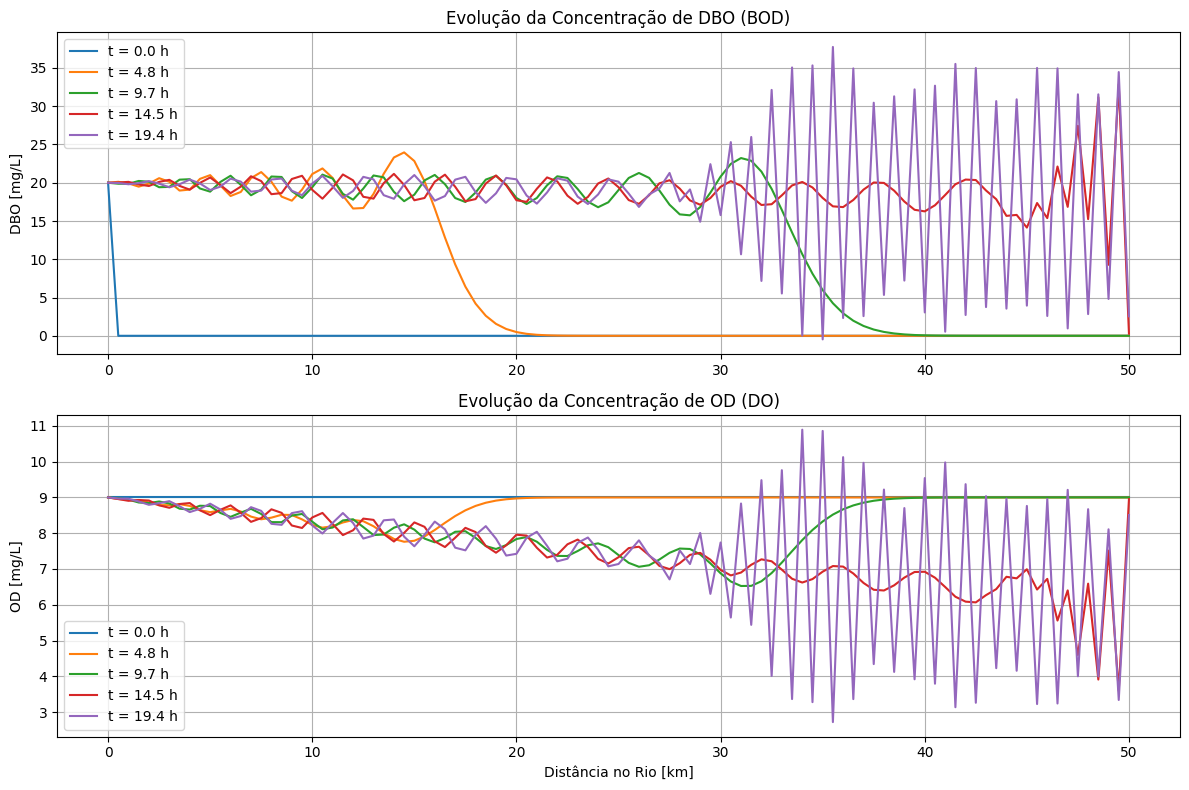

In [1]:
"""
Solução Numérica das EDPs de Streeter-Phelps Difusivas via Método das Linhas (MOL)
"""
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- Parâmetros Físicos e Bioquímicos ---
v = 1.0     # Velocidade do rio [m/s]
K = 0.5     # Coeficiente de dispersão [m²/s]
k1 = 0.3    # Taxa de consumo de OD pela DBO [1/dia]
k2 = 0.4    # Taxa de reaeração [1/dia]
k3 = 0.2    # Taxa de decaimento da DBO (linear) [1/dia]
Ds = 9.0    # Saturação de OD [mg/L]
ba = 0.0    # Fonte adicional de DBO [mg/L/dia] (assumida zero aqui)

# --- Conversão de unidades (dia para segundo) ---
day_to_sec = 24.0 * 3600.0
k1 /= day_to_sec
k2 /= day_to_sec
k3 /= day_to_sec
ba /= day_to_sec

# --- Parâmetros da Simulação Numérica ---
L = 50000.0  # Comprimento do rio [m] (50 km)
Nx = 100     # Número de intervalos da malha espacial (Nx+1 pontos)
dx = L / Nx  # Tamanho do passo espacial [m]
x_grid = np.linspace(0, L, Nx + 1) # Malha espacial

T_final = 1 * day_to_sec # Tempo final da simulação [s] (1 dia)
t_eval = np.linspace(0, T_final, 100) # Tempos para avaliação da solução

# --- Condições de Contorno ---
# Montante (x=0, i=0) - Tipo Dirichlet
b_in = 20.0  # Concentração de DBO na entrada [mg/L]
D_in = Ds    # Concentração de OD na entrada (saturado) [mg/L]
# Jusante (x=L, i=Nx) - Tipo Neumann (fluxo zero)
# Implementado dentro da função F(t, Y)

# --- Condição Inicial (t=0) ---
b_initial = np.zeros(Nx + 1)
D_initial = np.full(Nx + 1, Ds)
# Aplica condição de entrada na condição inicial no ponto x=0
b_initial[0] = b_in
D_initial[0] = D_in
# Pode-se definir uma condição inicial diferente, e.g., uma pluma inicial:
# plume_center = L / 5
# plume_width = L / 10
# b_initial = b_in * np.exp(-((x_grid - plume_center)**2) / (2 * plume_width**2))
# D_initial = Ds * np.ones_like(x_grid)

# --- Função para o Sistema de EDOs (Método das Linhas) ---
def streeter_phelps_pde_mol(t, y, Nx, dx, v, K, k1, k2, k3, Ds, ba, b_in, D_in):
    # y é um vetor contendo [b_0, b_1, ..., b_Nx, D_0, D_1, ..., D_Nx]
    b = y[:Nx+1]
    D = y[Nx+1:]
    
    # Inicializa vetores para as derivadas temporais
    dbdt = np.zeros(Nx + 1)
    dDdt = np.zeros(Nx + 1)
    
    # --- Aplica Condições de Contorno ---
    # Montante (Dirichlet): As concentrações são fixas, então as derivadas são zero.
    # (Alternativamente, podemos não incluir b_0, D_0 no vetor y e ajustar os índices)
    # Vamos fixar aqui para simplicidade da indexação na derivada.
    b[0] = b_in
    D[0] = D_in
    dbdt[0] = 0.0
    dDdt[0] = 0.0

    # --- Calcula Derivadas nos Pontos Internos (i = 1 a Nx-1) ---
    for i in range(1, Nx):
        # Derivadas espaciais (Diferenças Centradas)
        dbdx = (b[i+1] - b[i-1]) / (2 * dx)
        d2bdx2 = (b[i+1] - 2 * b[i] + b[i-1]) / (dx**2)
        dDdx = (D[i+1] - D[i-1]) / (2 * dx)
        d2Ddx2 = (D[i+1] - 2 * D[i] + D[i-1]) / (dx**2)
        
        # Termo de reação (linear f(b)=b)
        reaction_b = k3 * b[i]
        reaction_D_consumo = k1 * b[i]
        reaction_D_reaeracao = k2 * (Ds - D[i])
        
        # EDOs para o ponto i
        dbdt[i] = -v * dbdx + K * d2bdx2 - reaction_b + ba
        dDdt[i] = -v * dDdx + K * d2Ddx2 - reaction_D_consumo + reaction_D_reaeracao
        
    # --- Condição de Contorno Jusante (Neumann - fluxo zero) em i = Nx ---
    # Aproximação: ∂b/∂x = 0 => b_Nx = b_Nx-1 (ou usa ponto fantasma b_Nx+1 = b_Nx-1)
    # Usando ponto fantasma b_Nx+1 = b_Nx-1 na fórmula de diferenças centradas:
    dbdx_L = (b[Nx-1] - b[Nx-1]) / (2 * dx) # Advecção zero no ponto fantasma approx
    d2bdx2_L = (b[Nx-1] - 2 * b[Nx] + b[Nx-1]) / (dx**2)
    dDdx_L = (D[Nx-1] - D[Nx-1]) / (2*dx) # Advecção zero no ponto fantasma approx
    d2Ddx2_L = (D[Nx-1] - 2 * D[Nx] + D[Nx-1]) / (dx**2)
    
    # Outra aproximação mais simples (diferença para trás na derivada de 1a ordem):
    # dbdx_L = (b[Nx] - b[Nx-1]) / dx # = 0 (não ajuda na EDO)
    # Usaremos a aproximação de ponto fantasma que é mais comum para preservar a ordem

    reaction_b_L = k3 * b[Nx]
    reaction_D_consumo_L = k1 * b[Nx]
    reaction_D_reaeracao_L = k2 * (Ds - D[Nx])
        
    dbdt[Nx] = -v * dbdx_L + K * d2bdx2_L - reaction_b_L + ba
    dDdt[Nx] = -v * dDdx_L + K * d2Ddx2_L - reaction_D_consumo_L + reaction_D_reaeracao_L
    
    # Retorna o vetor achatado das derivadas
    dydt = np.concatenate((dbdt, dDdt))
    return dydt

# --- Resolve o Sistema de EDOs ---
y0 = np.concatenate((b_initial, D_initial)) # Vetor de condição inicial

print("Iniciando integração das EDOs...")
sol = solve_ivp(
    streeter_phelps_pde_mol, 
    [0, T_final], 
    y0, 
    method='RK45', 
    t_eval=t_eval, 
    args=(Nx, dx, v, K, k1, k2, k3, Ds, ba, b_in, D_in)
)
print("Integração concluída.")

# --- Processa e Visualiza os Resultados ---
if sol.success:
    # Extrai a solução nos tempos avaliados
    b_sol = sol.y[:Nx+1, :]
    D_sol = sol.y[Nx+1:, :]
    
    # Visualização
    plt.figure(figsize=(12, 8))
    
    # Plot DBO em diferentes tempos
    plt.subplot(2, 1, 1)
    for i in range(0, len(t_eval), len(t_eval)//5): # Plota alguns perfis de tempo
        plt.plot(x_grid / 1000, b_sol[:, i], label=f't = {t_eval[i]/3600:.1f} h')
    plt.title('Evolução da Concentração de DBO (BOD)')
    plt.ylabel('DBO [mg/L]')
    plt.legend()
    plt.grid(True)
    
    # Plot OD em diferentes tempos
    plt.subplot(2, 1, 2)
    for i in range(0, len(t_eval), len(t_eval)//5):
        plt.plot(x_grid / 1000, D_sol[:, i], label=f't = {t_eval[i]/3600:.1f} h')
    plt.title('Evolução da Concentração de OD (DO)')
    plt.xlabel('Distância no Rio [km]')
    plt.ylabel('OD [mg/L]')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Plot adicional: Heatmap (opcional, requer mais pontos)
    # plt.figure(figsize=(10, 5))
    # plt.contourf(x_grid / 1000, t_eval / 3600, D_sol, 50, cmap='viridis')
    # plt.colorbar(label='OD [mg/L]')
    # plt.xlabel('Distância [km]')
    # plt.ylabel('Tempo [h]')
    # plt.title('Mapa de Contorno da Concentração de OD')
    # plt.show()
else:
    print("Falha na integração numérica.")
    print(sol.message)


# Análise dos Resultados Espaço-Temporais

Os gráficos acima mostram a evolução das concentrações de DBO e OD ao longo do trecho do rio (`x`) em diferentes instantes de tempo (`t`).

* **DBO:** Observa-se a pluma de DBO entrando pela fronteira de montante (`x=0`) e sendo transportada (advecção) e espalhada (difusão) ao longo do rio, enquanto decai devido à reação bioquímica (`k3`). A concentração diminui à medida que avança para jusante e com o passar do tempo (para uma fonte constante na entrada, um perfil de estado estacionário pode ser atingido).
* **OD:** A famosa "curva de sag" se desenvolve tanto no espaço quanto no tempo. Perto da fonte de DBO, o OD diminui devido ao consumo (`k1`). Mais a jusante, à medida que a DBO decai, a reaeração (`k2`) se torna dominante e o OD começa a se recuperar em direção ao nível de saturação (`Ds`). Os gráficos mostram como a zona de mínimo OD (o ponto mais crítico da curva de sag) se forma e se move ao longo do rio com o tempo até atingir uma condição de equilíbrio (se aplicável).

**Interpretação:** Esta simulação permite visualizar como uma descarga contínua de DBO na entrada afeta a qualidade da água ao longo do rio e como o sistema evolui para um estado (potencialmente) estacionário. A localização e a profundidade da curva de sag são informações cruciais para a gestão ambiental.

**Influência dos Parâmetros:** A análise de sensibilidade (não realizada aqui, mas possível rodando a simulação com diferentes valores) mostraria como `v`, `K`, `k1`, `k2`, `k3` afetam a velocidade de propagação da pluma, a extensão da zona de impacto, a profundidade do mínimo de OD e o tempo para atingir o estado estacionário.

# Conclusões

Este notebook implementou com sucesso a solução numérica das EDPs difusivas de Streeter-Phelps utilizando o Método das Linhas com discretização por diferenças finitas. Esta abordagem permite simular a dinâmica espaço-temporal completa da DBO e do OD em um trecho de rio, superando as limitações da análise restrita a ondas viajantes.

**Principais Conclusões da Simulação:**
1.  O método MOL acoplado ao `solve_ivp` é eficaz para resolver este sistema de EDPs de advecção-difusão-reação.
2.  A simulação captura a formação e propagação da pluma de DBO e da curva de sag do OD, fornecendo uma visão detalhada da resposta do rio à poluição.
3.  A abordagem é geral e pode ser adaptada para diferentes condições iniciais, de contorno, geometrias de rio (com discretização mais avançada) e cinéticas de reação (e.g., Monod).

**Vantagens sobre a Abordagem Anterior (Ondas Viajantes/EDOs):**
* **Generalidade:** Resolve o problema completo, não apenas um tipo específico de solução.
* **Flexibilidade:** Permite simular transientes, respostas a condições iniciais variadas e fontes/sumidouros dependentes do espaço e tempo.

**Limitações e Próximos Passos:**
1.  **Precisão Numérica:** A precisão depende da discretização espacial (`Nx`) e temporal (tolerâncias do `solve_ivp`). Erros numéricos (como difusão numérica excessiva com diferenças centradas para advecção dominante) podem ocorrer. Esquemas de ordem superior ou métodos de upwinding para advecção podem ser necessários.
2.  **Estabilidade:** A escolha do passo de tempo implícita no `solve_ivp` (especialmente com métodos como 'BDF') ajuda na estabilidade, mas para esquemas explícitos, haveria restrições (condição CFL).
3.  **Custo Computacional:** Resolver um grande sistema de EDOs pode ser computacionalmente intensivo, especialmente para malhas finas ou tempos longos.
4.  **Cinética de Monod:** Implementar a cinética não-linear `f(b) = b / (K_b + b)` seria um próximo passo natural para maior realismo.
5.  **Validação:** Comparar os resultados com dados de campo ou soluções analíticas (para casos simplificados) é crucial para validar o modelo e o código.
6.  **Condições de Contorno:** Explorar implementações mais sofisticadas para a condição de contorno de jusante.

Em resumo, a solução direta das EDPs fornece uma ferramenta poderosa e flexível para a modelagem da qualidade da água, abordando as limitações e críticas levantadas sobre a abordagem anterior focada exclusivamente em EDOs de ondas viajantes.

# Referências

1.  Lawryshyn, A. *Travelling Waves of the Diffusive Streeter-Phelps Equations with Braun-Berthouex BOD Decay*. [Artigo base fornecido pelo usuário - incluir detalhes completos se disponíveis].
2.  Streeter, H. W., & Phelps, E. B. (1925). *A study of the pollution and natural purification of the Ohio River*. Public Health Bulletin No. 146. U.S. Public Health Service.
3.  Chapra, S. C. (1997). *Surface Water-Quality Modeling*. McGraw-Hill.
4.  LeVeque, R. J. (2007). *Finite Difference Methods for Ordinary and Partial Differential Equations*. SIAM.
5.  [Outras referências relevantes sobre MOL, diferenças finitas, ou modelagem de qualidade da água].